In [1]:
import os
import keras
import tensorflow
import numpy as np
import pandas as pd
import spectral as spy
import matplotlib.pyplot as plt
from Code.functions.class_ids import map_float_id2rgb
from Code.find_path_nextcloud import find_path_nextcloud
from Code.functions.combine_subimages import combine_subimages
from Code.functions.import_labeled_data import import_labeled_data
from Code.functions.build_samples_NN_for_pixel import import_samples_NN_for_pixel
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

In [14]:
# load model
model = keras.models.load_model('data/models/baseline1_nn_for_pixel.h5')

In [5]:
# import data
X_train, y_train, X_test, y_test = import_samples_NN_for_pixel(label_mapping='Ohne_Auto_See')

In [6]:
# prediction
y_pred_train = model.predict(X_train)

33000/33000 [==============================] - 26s 773us/step


In [7]:
# choose argmax
y_pred_train = y_pred_train.argmax(axis=1)
y_train = np.array(y_train).argmax(axis=1)

**Accuracy**

In [8]:
print(accuracy_score(y_true=y_train, y_pred=y_pred_train))

0.20646496212121213


**Confusions-Matrix**

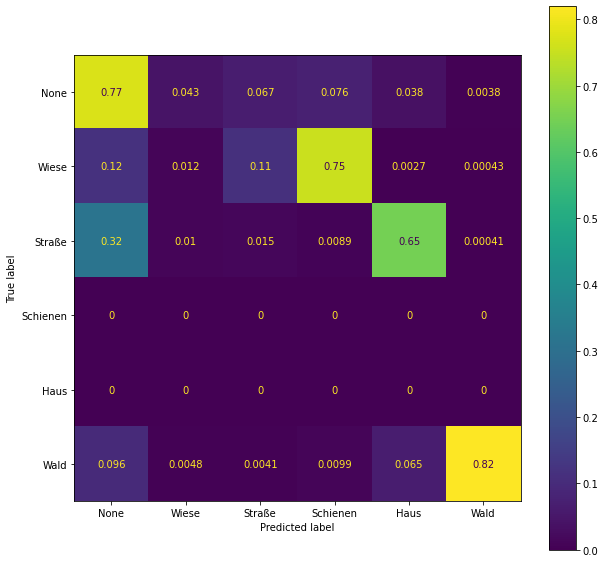

In [9]:
cm = confusion_matrix(y_true=y_train, y_pred=y_pred_train, labels=[0, 1, 2, 3, 4, 5], normalize='true')
cmp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['None', 'Wiese','Straße','Schienen','Haus','Wald'])
fig, ax = plt.subplots(figsize=(10, 10))
cmp.plot(ax=ax)
plt.show()

# Vorhersagen als Bild plotten

In [15]:
# Pfad Nextcloud bestimmen
path_nextcloud = find_path_nextcloud()

# Festlegung, welches Grid zusammengelegt werden soll
windowsize_r = 200
windowsize_c = 200

# Bestimmung annotation_folder
grid_folder = path_nextcloud + "Daten_Gyrocopter/Oldenburg/Teilbilder/grid_" + str(windowsize_r) + "_" + str(windowsize_c)
labeled_folder = grid_folder + '/labeled/'

df_annotations = import_labeled_data(path_labeled_folder=labeled_folder)
X = df_annotations.drop(columns=['label', 'picture_name'])
X = tensorflow.convert_to_tensor(X, dtype=tensorflow.float32)

In [17]:
# prediction
y_pred = model.predict(X)
# choose argmax
df_annotations['y_pred'] = y_pred.argmax(axis=1)

41250/41250 [==============================] - 43s 1ms/step


In [18]:
# Mapping class_id auf class_rgb
df = map_float_id2rgb(dataframe=df_annotations, column='y_pred')

# extract color values
df['class_color1'] = df['class_color'].apply(lambda x: x[0])
df['class_color2'] = df['class_color'].apply(lambda x: x[1])
df['class_color3'] = df['class_color'].apply(lambda x: x[2])

In [ ]:
for image_name in df['picture_name'].unique():
    image = df.loc[df['picture_name'] == image_name, ]

    # reshape pixel to image for annotation picture
    img_arr = np.array(image[['class_color1', 'class_color2', 'class_color3']])
    img_arr = np.reshape(img_arr, (200, 200, 3))

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img_arr)
    plt.show()
    # fig.savefig(image_name)

### Vorhersage Gesamtbild

In [2]:
# Pfad Nextcloud bestimmen
path_nextcloud = find_path_nextcloud()
path_X = path_nextcloud + 'Daten_Gyrocopter/Oldenburg/Teilbilder/grid_200_200/subimages/'
path_export = path_nextcloud + 'Daten_Gyrocopter/Oldenburg/predicted_subimages2/'

# df_all_images = import_labeled_data(path_labeled_folder=path_X, import_labeled_images=False)

In [8]:
# load model
model = keras.models.load_model('data/models/baseline1_nn_for_pixel.h5')

# Liste aller Dateien in annotation_folder erstellen
files = os.listdir(path_X)

# Aus Liste files .hdr Dateien löschen
for file in files:
    if not file.endswith('.dat'):
        files.remove(file)

if 'wrong_image_size' in files:
    files.remove('wrong_image_size')

if 'old'in files:
    files.remove('old')

# labeled Bilder erstellen
for filename in files:
    path_dat = path_X + '/' + os.path.splitext(filename)[0] + '.dat'
    path_hdr = path_X + '/' + os.path.splitext(filename)[0] + '.hdr'
    img = spy.envi.open(file=path_hdr, image=path_dat)

    arr = img.load()

    df = pd.DataFrame(arr.reshape(((arr.shape[0]*arr.shape[1]), arr.shape[2])))

    X = tensorflow.convert_to_tensor(df, dtype=tensorflow.float32)

    # prediction
    y_pred = model.predict(X)
    # choose argmax
    df['y_pred'] = y_pred.argmax(axis=1)

    arr_pred = np.reshape(np.array(df), (arr.shape[0], arr.shape[1], arr.shape[2]+1) )

    # save Subimage
    img.metadata['bands'] = arr.shape[2]+1
    path_export_file = path_export + os.path.splitext(filename)[0] + '.hdr'
    spy.envi.save_image(hdr_file=path_export_file, image=arr_pred,
                    dtype="float32", ext='.dat', interleave='bsq',
                    metadata=img.metadata, force=True)


1250/1250 [==============================] - 1s 748us/step


C:\Users\fgrassxx\AppData\Local\Temp\ipykernel_10636\2038773629.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


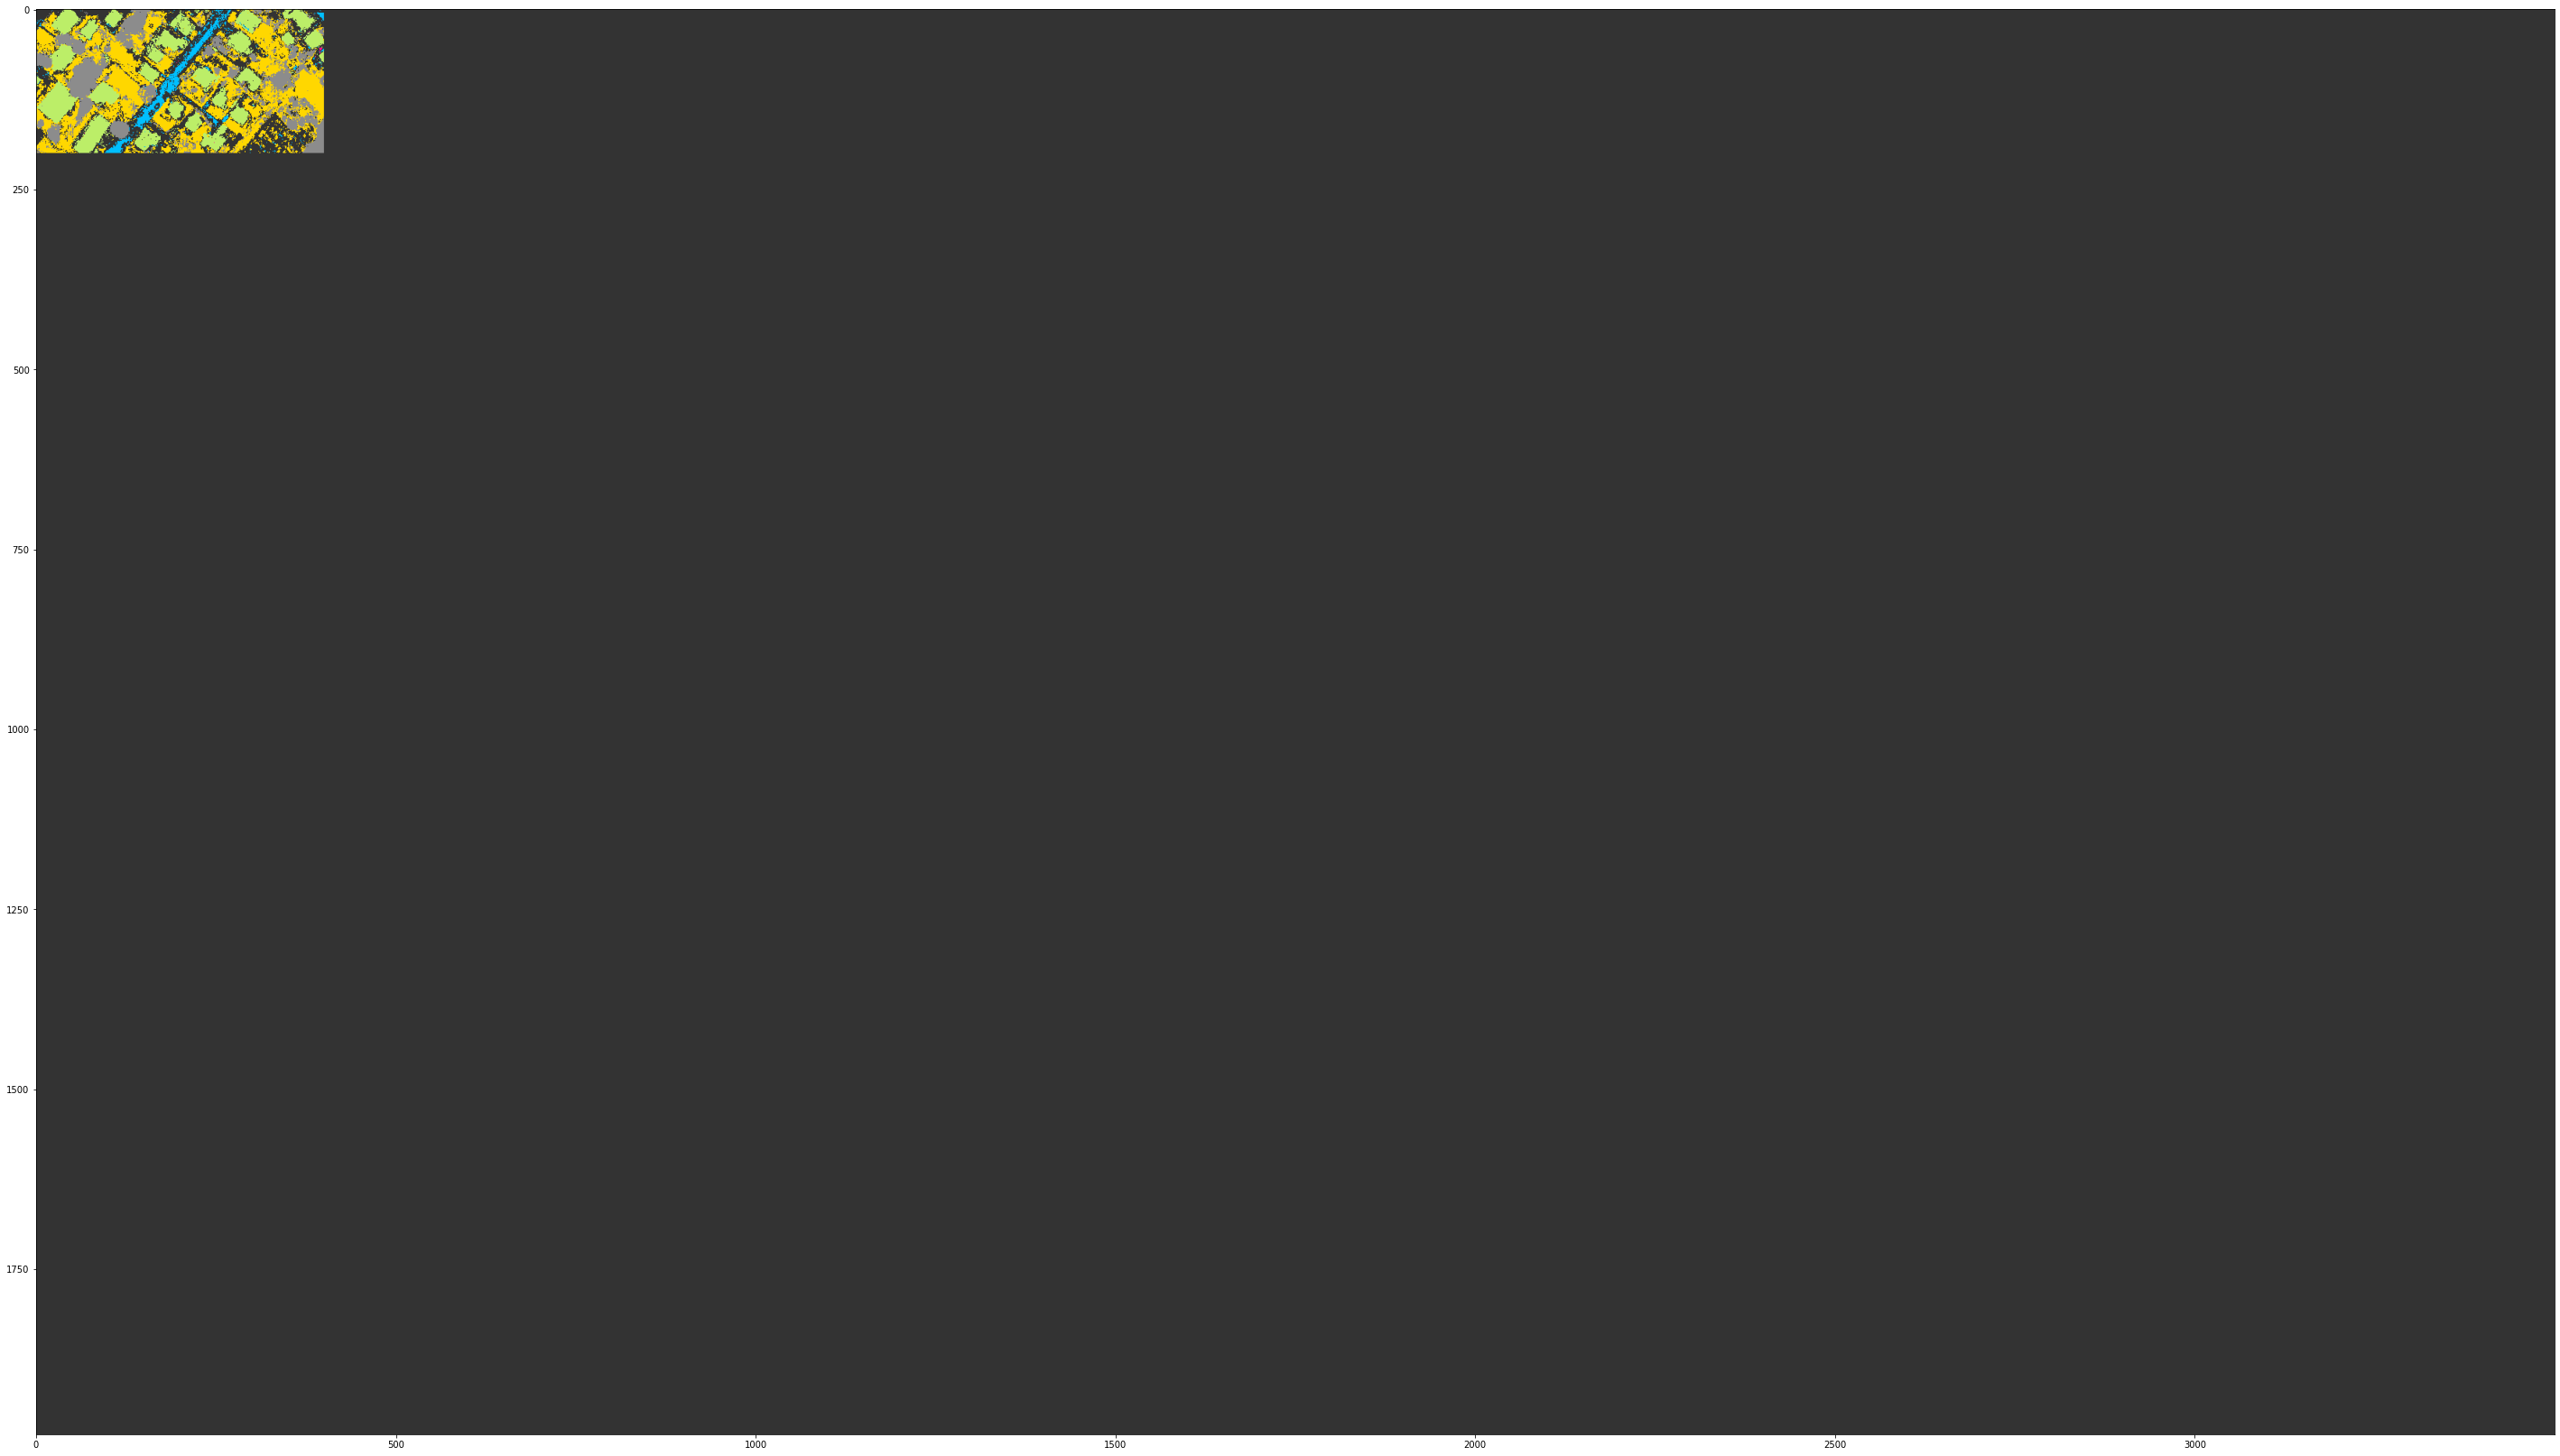

In [3]:
# define path with data
path_folder = path_nextcloud + 'Daten_Gyrocopter/Oldenburg'

# define HSI filenames
path_combined_hdr = path_folder + '/Oldenburg_combined_HSI_THERMAL_DOM.hdr'
path_combined_dat = path_folder + '/Oldenburg_combined_HSI_THERMAL_DOM.dat'

big_picture_pred = combine_subimages(hdr_file=path_combined_hdr, dat_file=path_combined_dat,
                                     path_grid_subimages=path_export,
                                     path_export='data/', window_width=200, window_height=200,
                                     combine_annotated_images=True)

arr = big_picture_pred.load()

# Umwandlung in DataFrame um class_id auf class_rgb zu mappen
df = pd.DataFrame(arr.reshape(6930000,110))
df = map_float_id2rgb(dataframe=df, column=109)

# extract color values
df['class_color1'] = df['class_color'].apply(lambda x: x[0])
df['class_color2'] = df['class_color'].apply(lambda x: x[1])
df['class_color3'] = df['class_color'].apply(lambda x: x[2])

# reshape pixel to image for annotation picture
img_arr = np.array(df[['class_color1', 'class_color2', 'class_color3']])
img_arr = np.reshape(img_arr, (1980, 3500, 3))

fig, ax = plt.subplots(figsize=(50, 30))
ax.imshow(img_arr)
fig.show()
# fig.savefig('data/annotated_picture/big_picture_annotations', dpi=300)